In [1]:
import numpy             as     np
import math
import matplotlib.pyplot as     plt
from   hyperfit.linfit   import LinFit
from   astropy.table     import Table
from   astropy.cosmology import FlatLambdaCDM
from   matplotlib.pyplot import cm
import matplotlib
from   scipy.special     import gamma
from   scipy             import interpolate
from   scipy             import stats

import pickle
import time
import progressbar
from   useful_functions  import *

#For making multiple page pdfs
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# _________________________________________________________
# _________________________________________________________
# -- Import files -- #
#                                       ... must always run
# _________________________________________________________

#First import the catalogue into an astropy.table (This is the catalogue I made with physical units included)
print('Reading in catalogues...')

#Path where all the files are for this/ where this code is located
path = '/home/jenniferhardwick/Insync/21514305@student.uwa.edu.au/OneDrive Biz/PhD/Project2_codes/'

#-------
#-------
#Switch to True or False depending if you want to have MW Extinction
MW_Extinction_On = True
#-------
#-------

# --
#Loading files from "BuildingProfiles_of_xGASS.ipynb"
if MW_Extinction_On:
    mydata = Table.read(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL+MWExtinction_v4.fits')
else:
    mydata = Table.read(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL_v4.fits')
    
# -- For some reason it imports strings as 'byte10' instead, so convert them to strings:
key = mydata.keys() 
for idx in range(len(key)):
    if mydata.dtype[idx] == object:
        mydata[key[idx]] = mydata[key[idx]].str.decode("utf-8")

#--
        
print('Catalogues loaded')

#Define our cosmology to be flat with the following values.
cosmo = FlatLambdaCDM(H0=70,Om0=0.3,Tcmb0 = 2.725)

Reading in catalogues...
Catalogues loaded


In [3]:
i = mydata['i']

HI = mydata['HIconf_flag'] # 0        = HI Detected no confusion, 
                           # 1        = HI detected and definite confusion
                           # 0<flag<1 = HI detected and possible confusion
                           # -99      = HI not detected

Model = mydata['Model'] # 0  = 2 component
                        # 1  = pure disk
                        # 2  = pure bulge
                        # -1 = no fit possible
            
#----------------------------------------------------------------------------------

In [4]:
GASSID_temp = np.array(mydata['GASSID'][(i > 30) & (HI == 0)])
GASSID = []
for g in GASSID_temp:
    GASSID.append(int(g[4:]))
GASSID = np.array(GASSID)

In [5]:
RA        = np.array(mydata['RA'][          (i > 30) & (HI == 0)])
DEC       = np.array(mydata['DEC'][         (i > 30) & (HI == 0)])
zSDSS     = np.array(mydata['zSDSS'][       (i > 30) & (HI == 0)])
b_a       = np.array(mydata['axrat'][       (i > 30) & (HI == 0)])
incl      = np.array(i[                     (i > 30) & (HI == 0)])
SFR       = np.array(mydata['SFR'][         (i > 30) & (HI == 0)])
EnvCode   = np.array(mydata['EnvCode'][     (i > 30) & (HI == 0)])
mol_flag  = np.array(mydata['H2_flag'][     (i > 30) & (HI == 0)]) #In "mydata" there is a 0 = detection, 1 = upper limit, 2 = Approximation from HI
mol_flag[mol_flag==2] = 1                                          #But ultimately we only care about 0 = detection and 1 = used an approx. to determine mol mass
V_rot_HI  = np.array(mydata['rot_velocity'][(i > 30) & (HI == 0)])
lg_M_HI   = np.array(mydata['lgMHI'][       (i > 30) & (HI == 0)])
lg_M_mol  = np.array(mydata['M_H2'][        (i > 30) & (HI == 0)]) 
B_T       = np.array(mydata['B/T'][         (i > 30) & (HI == 0)])

In [6]:
import pandas            as     pd

rob_path = '/home/jenniferhardwick/Insync/21514305@student.uwa.edu.au/OneDrive Biz/PhD/xGASS_Decomposition_Catalogue/Catalogues/'

robdata = pd.read_csv(rob_path+'xGASS_Bulge-Disk_Decomposition_Master_10-09-19.csv')

order = []
for g in mydata['GASSID'][(i > 30) & (HI == 0)]: #For every id in my data
    order.append(np.argwhere(np.array(robdata.GASSID) == g)[0][0]) #find that ID in Robins and record its location
order = np.array(order)

B_T_i     = np.array(robdata['B2T_i'][order]) #Add B_T for i-band as well

In [7]:
Re_hl    = []
Re_hm    = []
M_star_D = [] 
j_star_D = [] 
M_star_T = []
j_star_T = [] 
for ii,m in enumerate(mydata['Model']):
    if m ==  0:
        Re_hl.append(mydata['reT_r_kpc'][ii])
        Re_hm.append( mydata['rmT_kpc_fix'][ii])
        
        M_star_D.append(mydata['TotMstar_recover_fixD'][ii])
        j_star_D.append(mydata['j_mustar_10Re_brD'][ii])
        
        M_star_T.append(mydata['TotMstar_recover_fixT'][ii])
        j_star_T.append(mydata['j_mustar_10Re_brT'][ii])
        
    elif m == 1:
        Re_hl.append(mydata['re_r_kpc'][ii])
        Re_hm.append( mydata['rm_kpc_fix'][ii])
        
        M_star_D.append(mydata['TotMstar_recover_fix'][ii])
        j_star_D.append(mydata['j_mustar_10Re_brT'][ii])
        
        M_star_T.append(mydata['TotMstar_recover_fix'][ii])
        j_star_T.append(mydata['j_mustar_10Re_brT'][ii])
        
    elif m == 2:
        Re_hl.append(mydata['re_r_kpc'][ii])
        Re_hm.append( mydata['rm_kpc_fix'][ii])
        
        M_star_D.append(0.0)
        j_star_D.append(0.0)
        
        M_star_T.append(mydata['TotMstar_recover_fix'][ii])
        j_star_T.append(mydata['j_mustar_10Re_brT'][ii])
        
    else:
        Re_hl.append(np.float('nan'))
        Re_hm.append(np.float('nan'))
        M_star_D.append(np.float('nan'))
        j_star_D.append(np.float('nan'))
        M_star_T.append(np.float('nan'))
        j_star_T.append(np.float('nan'))
        
Re_hl    = np.array(Re_hl) 
Re_hm    = np.array(Re_hm)        
M_star_D = np.array(M_star_D)
j_star_D = np.array(j_star_D)
M_star_T = np.array(M_star_T)
j_star_T = np.array(j_star_T)

#---

Re_half_light  = np.array(Re_hl[(i > 30) & (HI == 0)])
Re_half_mass   = np.array(Re_hm[(i > 30) & (HI == 0)])

lg_M_star_disk = np.array(M_star_D[(i > 30) & (HI == 0)]) 
lg_M_star_disk[Model[(i>30)&(HI==0)]==2] = float('nan') #Set disk properties of pure bulges to a nan
j_star_disk    = np.array(j_star_D[(i > 30) & (HI == 0)]) 
j_star_disk[Model[(i>30)&(HI==0)]==2] = float('nan') #Set disk properties of pure bulges to a nan

lg_M_star_total = np.array(M_star_T[(i > 30) & (HI == 0)])                   
j_star_total    = np.array(j_star_T[(i > 30) & (HI == 0)]) 



<ipython-input-7-fc2cdc166f1c>:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Re_hl.append(np.float('nan'))
<ipython-input-7-fc2cdc166f1c>:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Re_hm.append(np.float('nan'))
<ipython-input-7-fc2cdc166f1c>:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To si

In [8]:
j_star_total_bnr = np.array(mydata['j_mustar_10Re_bnrT'][(i>30)&(HI==0)])
j_star_total_Ir  = np.array(mydata['j_Ir_10Re_brT'][     (i>30)&(HI==0)])

In [9]:
lg_M_bar_disk  = np.array(np.log10(mydata['M_baryon_D'][(i>30)&(HI==0)]))
lg_M_bar_disk[Model[(i>30)&(HI==0)]==2] = float('nan') #Set disk properties of pure bulges to a nan
lg_M_bar_total = np.array(np.log10(mydata['M_baryon_T'][(i>30)&(HI==0)]))

j_bar_disk  = np.array(mydata['j_baryon_D'][(i>30)&(HI==0)])
j_bar_disk[Model[(i>30)&(HI==0)]==2] = float('nan') #Set disk properties of pure bulges to a nan
j_bar_total = np.array(mydata['j_baryon_T'][(i>30)&(HI==0)])

f_atm_disk  = np.array(mydata['fatm_D'][(i>30)&(HI==0)]) #i.e. 1.35 MHI / Mbar_disk
f_atm_disk[Model[(i>30)&(HI==0)]==2] = float('nan') #Set disk properties of pure bulges to a nan
f_atm_total = np.array(1.35*(10**lg_M_HI)/(10**lg_M_bar_total)) #i.e. 1.35 MHI / Mbar_diskf_atm_total = 1.35*(10**lg_M_HI)/(10**) #i.e. 1.35 MHI / Mbar_disk

In [10]:
RA_sort_idx = sorted(range(len(RA)), key=lambda k: RA[k])

In [15]:
mydata_subset = Table([GASSID[RA_sort_idx],  
                       RA[RA_sort_idx],  
                       DEC[RA_sort_idx],  
                       zSDSS[RA_sort_idx],  
                       b_a[RA_sort_idx],  
                       incl[RA_sort_idx],  
                       SFR[RA_sort_idx],  
                       EnvCode[RA_sort_idx],  
                       mol_flag[RA_sort_idx],  
                       Re_half_light[RA_sort_idx],  
                       Re_half_mass[RA_sort_idx],  
                       V_rot_HI[RA_sort_idx],  
                       lg_M_star_disk[RA_sort_idx],  
                       lg_M_star_total[RA_sort_idx],  
                       lg_M_HI[RA_sort_idx],  
                       lg_M_mol[RA_sort_idx],  
                       lg_M_bar_disk[RA_sort_idx],  
                       lg_M_bar_total[RA_sort_idx],  
                       B_T[RA_sort_idx],  
                       B_T_i[RA_sort_idx],  
                       f_atm_disk[RA_sort_idx],  
                       f_atm_total[RA_sort_idx],  
                       j_star_disk[RA_sort_idx],  
                       j_star_total[RA_sort_idx],  
                       j_star_total_bnr[RA_sort_idx],  
                       j_star_total_Ir[RA_sort_idx],  
                       j_bar_disk[RA_sort_idx],  
                       j_bar_total[RA_sort_idx]],
                names=('GASSID','RA','DEC','zSDSS','b_a','incl','SFR','EnvCode','mol_flag','Re_half_light','Re_half_mass','V_rot_HI','lg_M_star_disk','lg_M_star_total','lg_M_HI','lg_M_mol','lg_M_bar_disk','lg_M_bar_total','B_T','B_T_i','f_atm_disk','f_atm_total','j_star_disk','j_star_total','j_star_total_bnr','j_star_total_Ir','j_bar_disk','j_bar_total'))

mydata_subset.write('/home/jenniferhardwick/Insync/21514305@student.uwa.edu.au/OneDrive Biz/PhD/MyPapers/ObreschkowRelationPaper/xGASS_AngularMomentum.fits',overwrite=True)



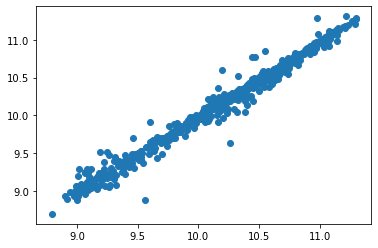

In [16]:
         
plt.scatter(lg_M_star_total,mydata['log10TotM*T'][(i>30)&(HI==0)])

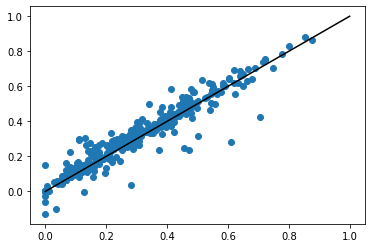

In [17]:
test_B2T = (10**lg_M_star_total - 10**lg_M_star_disk) / 10**lg_M_star_total
plt.scatter(B_T,test_B2T)
plt.plot([0,1],[0,1],color='k')

In [18]:
for ii,m in enumerate(mydata['Model'][(i>30)&(HI==0)]):
    if m ==2:
        print(j_star_total_bnr[ii])

0.0
0.0
0.0
0.0
0.0
